In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from utility.graphing_tools import single_dim_comparison, generate_latex_table_from_csvs, method_name_coverter
from utility.exps import run_synthetic_experiment

In [2]:
method_list = ["Point_CHR", "Unscaled", "Bonferroni", "Empirical_copula", "TSCP_R", "TSCP_GWC", "TSCP_S"]
method_name_list = method_name_coverter(method_list=method_list)

# Testing Coverage on Four Distributions

We test all methods discussed in the experiment section of our paper on four different distributions: Gaussian, Gaussian with unit noise, Laplace, Gamma, Mixed.
We report test coverage, volume, and runtime with their one standard deviation. 

## Experiements

In [3]:
dim_list = [2, 10]
sample_list = [30, 50, 100, 300, 500]
alpha_list = [0.1]
trial = 200
noise_list_unit = [np.repeat(1, 2), np.repeat(1, 10)]

In [15]:
noise_type_list = ["Gaussian", "Unit_Gaussian", "Laplace", "Gamma", "Mixed"]

In [ ]:
for noise_type in noise_type_list:

    if noise_type == "Unit_Gaussian":
        for method in method_list:
            results = run_synthetic_experiment(dim_list=dim_list, sample_list=sample_list, alpha_list=alpha_list, noise_type="Gaussian", trials=200, noises_list=noise_list_unit, method=method)
            results.to_csv("syn_exps/gaussian/"+method.lower()+"_"+noise_type.lower()+".csv")
    else:
        for method in method_list:
            results = run_synthetic_experiment(dim_list=dim_list, sample_list=sample_list, alpha_list=alpha_list, noise_type=noise_type, trials=200, method=method)
            results.to_csv("syn_exps/"+noise_type.lower()+"/"+method.lower()+"_"+noise_type.lower()+".csv")


d:\anaconda\Lib\site-packages\numpy\core\_methods.py:173: RuntimeWarning: invalid value encountered in subtract
  x = asanyarray(arr - arrmean)
d:\anaconda\Lib\site-packages\numpy\core\_methods.py:173: RuntimeWarning: invalid value encountered in subtract
  x = asanyarray(arr - arrmean)


## Graphs

In [12]:
method_list_graph1 = ["Point_CHR", "Unscaled", "Bonferroni", "Empirical_copula", "TSCP_R", "TSCP_S"]
method_name_list_graph1 = method_name_coverter(method_list_graph1)

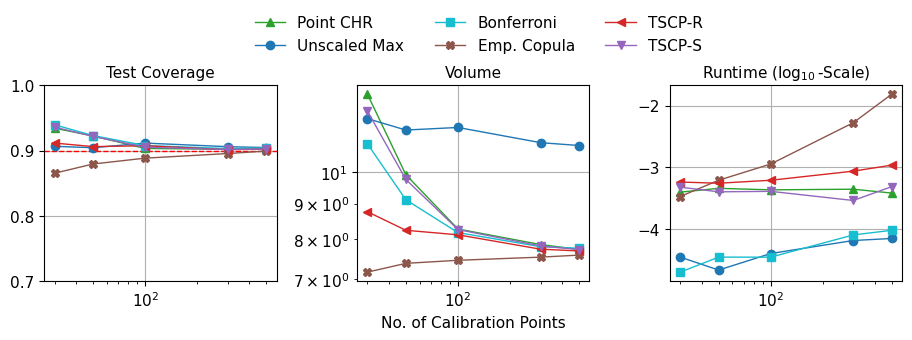

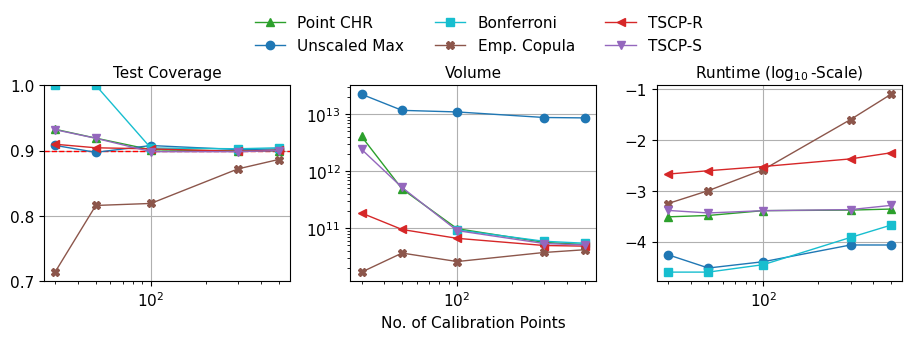

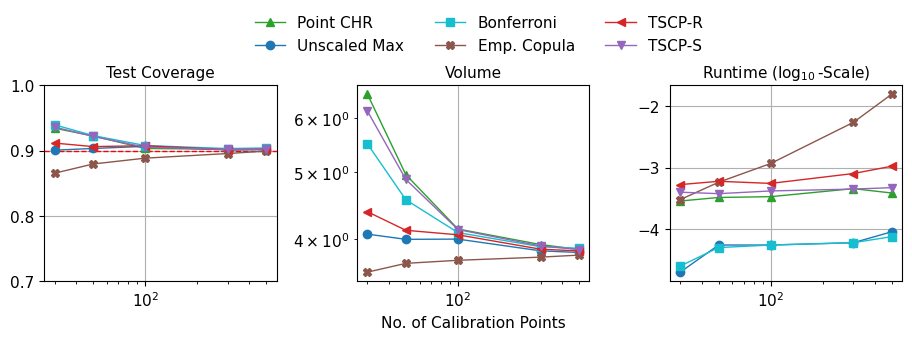

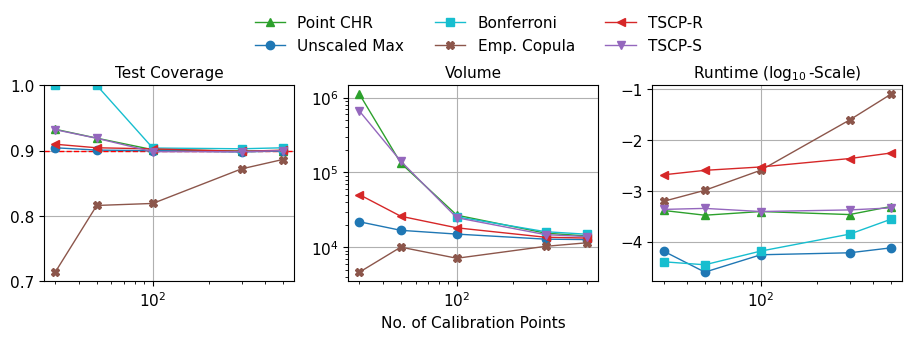

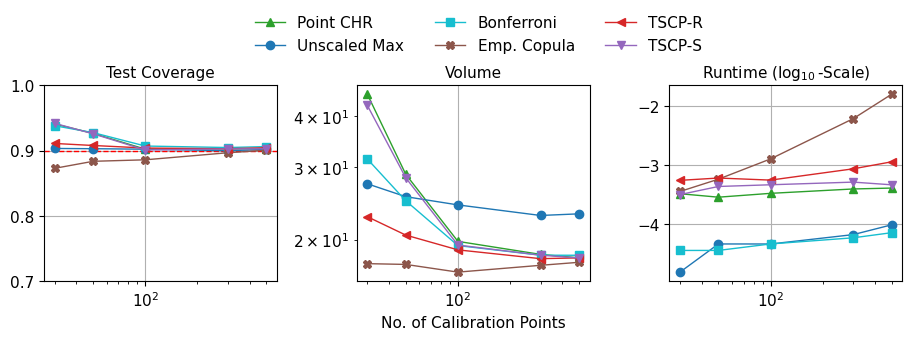

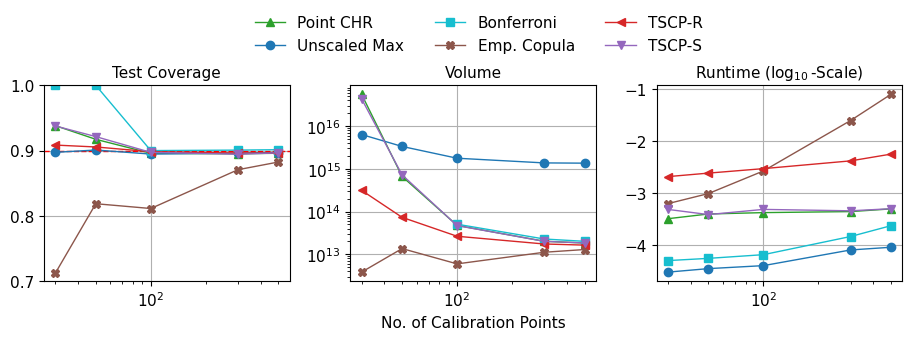

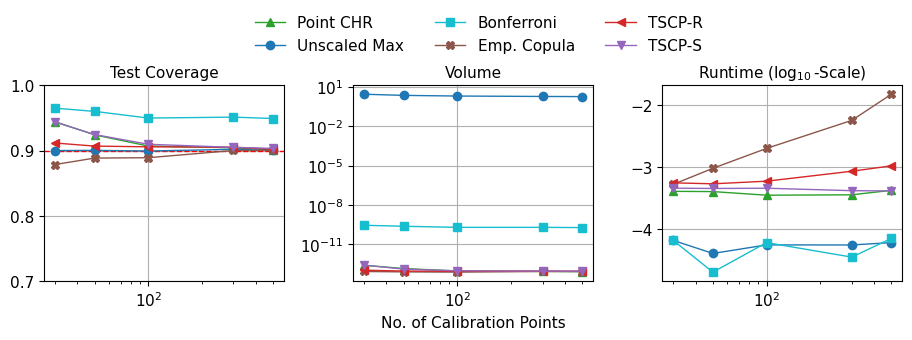

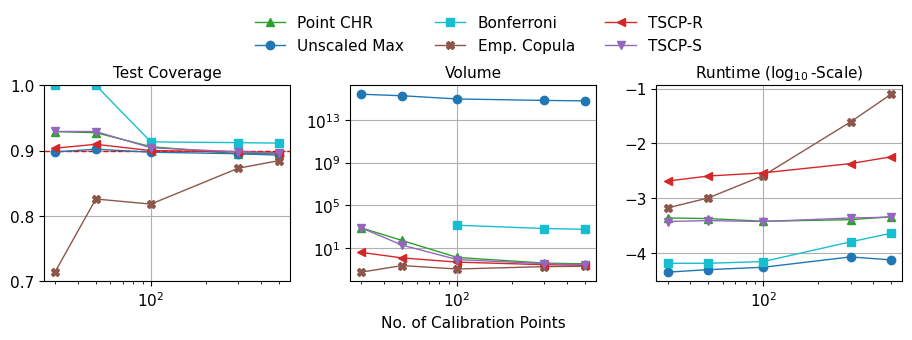

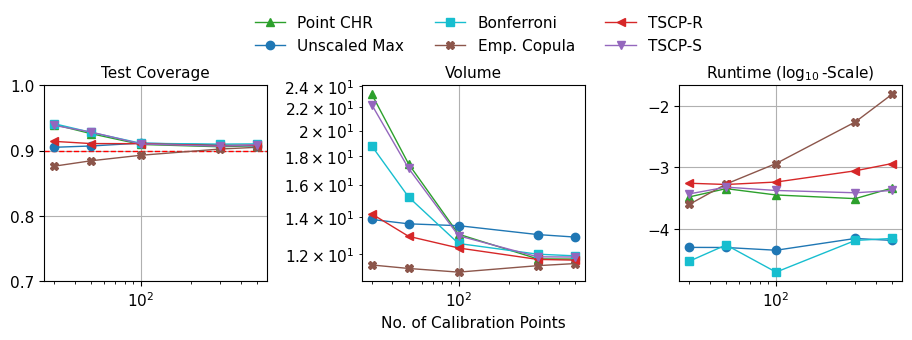

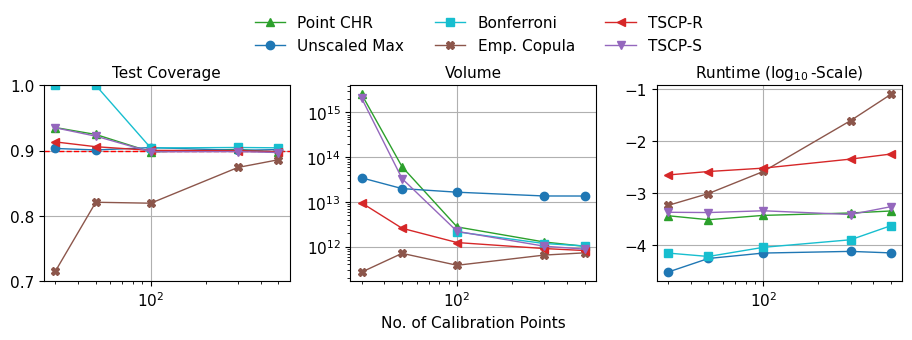

In [18]:
for noise_type in noise_type_list:

    folder_name = "gaussian" if noise_type == "Unit_Gaussian" else noise_type.lower()
    dict = {}
    for method in method_list_graph1:
        results = pd.read_csv("syn_exps/"+folder_name+"/"+method.lower()+"_"+noise_type.lower()+".csv")
        dict[method_name_list_graph1[method]] = results
    for dim in dim_list:
        fig, axes = single_dim_comparison(df_dict=dict, dim=dim, n_cols = 3, error_bar=False, bbox_to_anchor=(0.45, 1.15), loc="upper center")
        fig.savefig("syn_exps/figures/"+noise_type.lower()+"_"+f"{dim}"+"d.pdf", bbox_inches='tight')



In [11]:
a=5
print(f"{a}")

5


# Testing Our Method on Cauchy 

One of the assumption we have on the residuals is that they must have finite variance. To see how robust our method is, we test it using the Cauchy distribution, which is known to have infinite variance.

## Experiements

In [ ]:
for method in method_list:
    results = run_synthetic_experiment(dim_list=dim_list, sample_list=[30, 50, 100, 300, 500, 1000], alpha_list=alpha_list, noise_type="Cauchy", trials=200, method=method)
    results.to_csv("syn_exps/cauchy/"+method.lower()+"_cauchy.csv")

d:\anaconda\Lib\site-packages\numpy\core\_methods.py:173: RuntimeWarning: invalid value encountered in subtract
  x = asanyarray(arr - arrmean)
d:\anaconda\Lib\site-packages\numpy\core\_methods.py:173: RuntimeWarning: invalid value encountered in subtract
  x = asanyarray(arr - arrmean)


## Graphs

In [7]:
dict_cauchy = {}
for method in method_list_graph1:
    results = pd.read_csv("syn_exps/cauchy/"+method.lower()+"_cauchy.csv")
    dict_cauchy[method_name_list_graph1[method]] = results

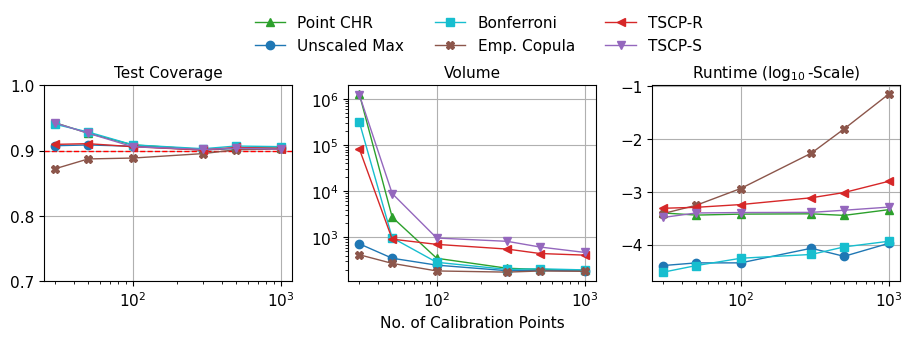

In [8]:
fig, axes = single_dim_comparison(df_dict=dict_cauchy, dim=2, n_cols = 3, error_bar=False, bbox_to_anchor=(0.45, 1.15), loc="upper center")
fig.savefig("syn_exps/figures/cauchy_2d.pdf", bbox_inches='tight')

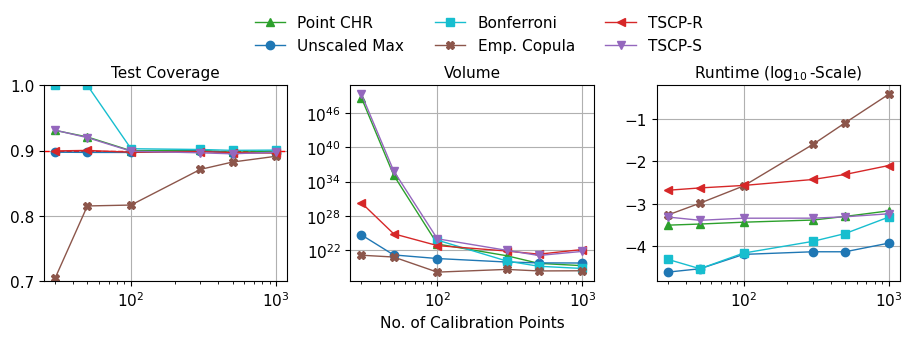

In [9]:
fig, axes = single_dim_comparison(df_dict=dict_cauchy, dim=10, n_cols = 3, error_bar=False, bbox_to_anchor=(0.45, 1.15), loc="upper center")
fig.savefig("syn_exps/figures/cauchy_10d.pdf", bbox_inches='tight')